In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.7.0


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 39s 0us/step


In [4]:
data_dir

WindowsPath('C:/Users/jesung/.keras/datasets/flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


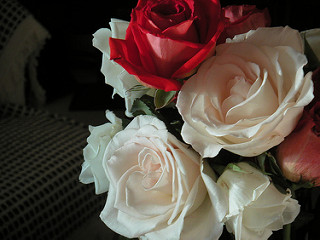

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# tf.keras.preprocessing을 사용하여 로드하기

## 데이터셋 만들기

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화하기

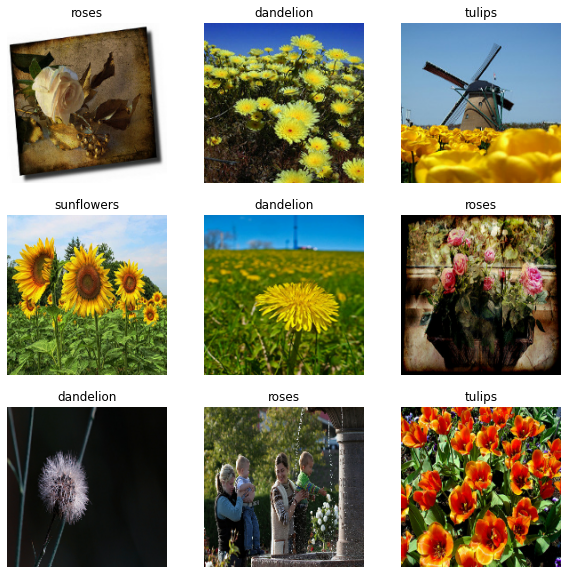

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### 데이터 표준화

In [19]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [20]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


### 성능을 위한 데이터세트 구성하기

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 훈련하기

In [23]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 15s 51ms/step - loss: 1.3274 - accuracy: 0.4183 - val_loss: 1.1389 - val_accuracy: 0.5463
Epoch 2/3
92/92 [==============================] - 2s 19ms/step - loss: 1.0695 - accuracy: 0.5664 - val_loss: 0.9815 - val_accuracy: 0.5967
Epoch 3/3
92/92 [==============================] - 2s 20ms/step - loss: 0.9305 - accuracy: 0.6359 - val_loss: 0.9390 - val_accuracy: 0.6335


# 다른 방법

## 미세 제어를 위해 tf.data 사용하기

In [28]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [29]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\jesung\\.keras\\datasets\\flower_photos\\roses\\13342823005_16d3df58df_n.jpg'
b'C:\\Users\\jesung\\.keras\\datasets\\flower_photos\\tulips\\14090534565_5857ce4b7c_n.jpg'
b'C:\\Users\\jesung\\.keras\\datasets\\flower_photos\\daisy\\14523675369_97c31d0b5b.jpg'
b'C:\\Users\\jesung\\.keras\\datasets\\flower_photos\\tulips\\8697784345_e75913d220.jpg'
b'C:\\Users\\jesung\\.keras\\datasets\\flower_photos\\roses\\18990187093_09f2bff8fc_m.jpg'


In [30]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [31]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [32]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


#### 파일 경로를 (img, label) 쌍으로 변환하는 간단한 함수 작성

In [33]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [34]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [35]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [36]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [39]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

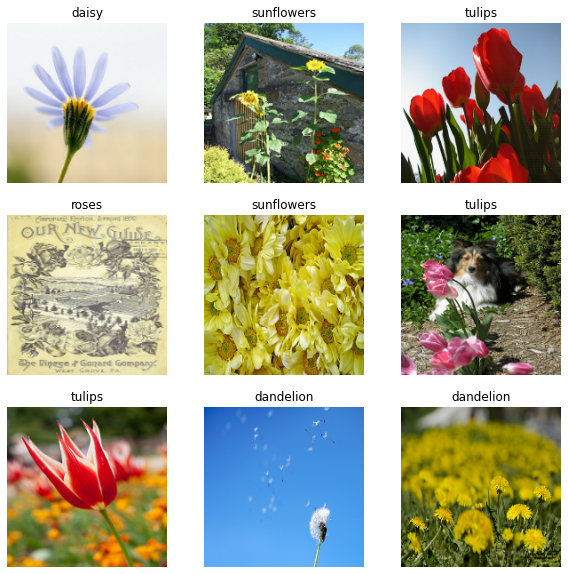

In [41]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [42]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3)

Epoch 1/3
92/92 [==============================] - 4s 32ms/step - loss: 0.7807 - accuracy: 0.6921 - val_loss: 0.8272 - val_accuracy: 0.6744
Epoch 2/3
92/92 [==============================] - 2s 22ms/step - loss: 0.6001 - accuracy: 0.7718 - val_loss: 0.9241 - val_accuracy: 0.6703
Epoch 3/3
92/92 [==============================] - 2s 22ms/step - loss: 0.3980 - accuracy: 0.8518 - val_loss: 1.0425 - val_accuracy: 0.6798
